# Transforming Data and Dealing with Categorical Variables

### Encoding Categorical Variables, Normalizing Variables, ~~Incorporating Interaction and Polynomial Terms, ETC~~


Today's focus is all about translating raw **data** into useful **information** that a model can understand and properly use. 

## Set Up

New dataset for today! Insurance costs

My source: https://www.kaggle.com/mirichoi0218/insurance (they got the idea for cleaning up the original open source data from [Machine Learning with R](https://www.packtpub.com/product/machine-learning-with-r-third-edition/9781788295864))

In [1]:
# Initial imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df = pd.read_csv('data/insurance.csv')

In [3]:
# explore the data
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


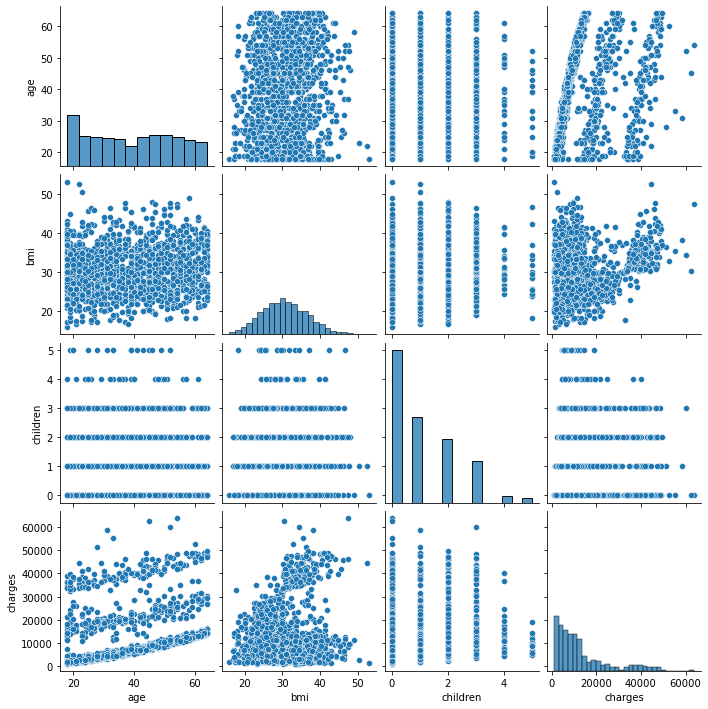

In [6]:
# visualize relationships between numeric columns
sns.pairplot(df)
plt.show()

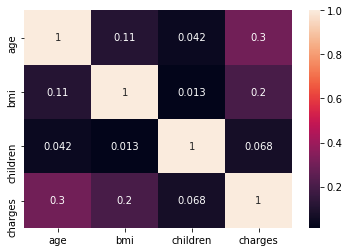

In [7]:
# visualize correlations between numeric columns
sns.heatmap(df.corr(), annot=True)
plt.show()

### Initial Model!

Let's run a kitchen sink model! Ignoring categorical columns, let's just throw all of our numeric columns into a model and see how we do.

In [8]:
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [9]:
# set our X and y
# ignore our categorical columns for now
used_cols = ['age', 'bmi', 'children']
X = df[used_cols]
y = df['charges']

In [10]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [11]:
# scale our data
scaler = StandardScaler()
# fit scaler on train data
scaler.fit(X_train)
# transform both train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# now, let's model!
lr_base = sm.OLS(y_train, sm.add_constant(X_train_scaled)).fit()

# grab predictions for train and test set
train_preds = lr_base.predict(sm.add_constant(X_train_scaled))
test_preds = lr_base.predict(sm.add_constant(X_test_scaled))

In [14]:
# evaluate
print(f"Train R2 Score: {r2_score(y_train, train_preds):.3f}")
print(f"Test R2 Score: {r2_score(y_test, test_preds):.3f}")

Train R2 Score: 0.117
Test R2 Score: 0.127


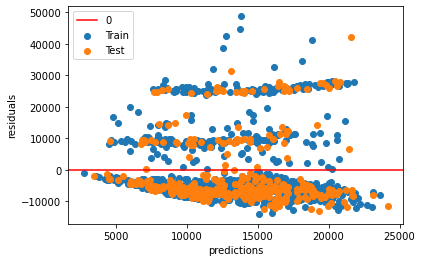

In [15]:
# let's look at our residuals
# for our full model
plt.scatter(train_preds, y_train-train_preds, label='Train')
plt.scatter(test_preds, y_test-test_preds, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

### Evaluate: How'd we do? What do you notice?

- R2 of .127 on test set - objectively bad
- we've violated 4/5 assumptions of linear regression - have more work to do!


In [16]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Encoding Categorical Variables

How do we bring in those categorical columns? By **encoding** them - translating the string variables into useful numbers the model can hopefully understand and take meaning from.

### Most Common Encoding Method: One Hot Encoding (OHE)

One very effective way of dealing with categorical variables is to dummy them out, a process also known as One Hot Encoding. What this involves is making a new column for _each categorical value_ in the column we're dummying out.

These new columns are turned into binaries, with a 1 representing the presence of the relevant categorical value.


For an example in our data: we have a column called `region`:

In [17]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [18]:
df['region'].head()

0    southwest
1    southeast
2    southeast
3    northwest
4    northwest
Name: region, dtype: object

With OHE, the result will either be three or four new columns: `is_southeast`, `is_northwest`, `is_southwest`, `is_northeast`

For the head of this data:

| `is_southeast` | `is_northwest` | `is_southwest` | `is_northeast` |
| -------------- | -------------- | -------------- | -------------- | 
| 0 | 0 | 1 | 0 |
| 1 | 0 | 0 | 0 |
| 1 | 0 | 0 | 0 |
| 0 | 1 | 0 | 0 |
| 0 | 1 | 0 | 0 |

Why could this result in three columns instead of four? We often drop the first column, and allow the model to capture that value by having zeros in all other columns. This reduces the **multicollinearity** between these newly created columns.

We'll explore two methods to one hot encode our features: a pandas method, which is easy but does not allow for the same transformation on both train and test, and a sklearn method, which learns the patterns and can then later transform test in the same way.

#### With Pandas' `get_dummies()`

In [20]:
# Let's look at the columns we have
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [21]:
# Let's define a list of our categorical columns
cat_cols = ['sex', 'smoker', 'region']

In [22]:
# And a list of our full X columns
# Fun trick!
x_cols = [*used_cols, *cat_cols]

In [23]:
x_cols

['age', 'bmi', 'children', 'sex', 'smoker', 'region']

In [24]:
df[x_cols].head()

,age,bmi,children,sex,smoker,region
0,19,27.900,0,female,yes,southwest
1,18,33.770,1,male,no,southeast
2,28,33.000,3,male,no,southeast
3,33,22.705,0,male,no,northwest
4,32,28.880,0,male,no,northwest


In [27]:
# one hot encode variables
df_ohe = pd.get_dummies(df[x_cols], # note that we run it on all X cols
                        columns=cat_cols, # but only encode cat cols
                        drop_first=True) # drop first for multicollinearity
print(df_ohe.shape)
df_ohe.head()

(1338, 8)


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,1,0,0,1
1,18,33.770,1,1,0,0,1,0
2,28,33.000,3,1,0,0,1,0
3,33,22.705,0,1,0,1,0,0
4,32,28.880,0,1,0,1,0,0


#### With `sklearn`'s One Hot Encoder

In [28]:
# Let's import two things from SKLearn that will make encoding these columns easy
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

In [29]:
# Re-define our X value to include ALL columns
X = df[x_cols]
X.head()

,age,bmi,children,sex,smoker,region
0,19,27.900,0,female,yes,southwest
1,18,33.770,1,male,no,southeast
2,28,33.000,3,male,no,southeast
3,33,22.705,0,male,no,northwest
4,32,28.880,0,male,no,northwest


In [30]:
# New train-test split for the new X
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [32]:
# create an encoder object. This will help us to convert
# categorical variables to new columns
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')

# Create an columntransformer object.
# This will help us to merge transformed columns
# with the rest of the dataset.
ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')
ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [34]:
# can display as a dataframe like so
pd.DataFrame(X_train_enc, columns= ct.get_feature_names()).head(10)

,ohe__x0_male,ohe__x1_yes,ohe__x2_northwest,ohe__x2_southeast,ohe__x2_southwest,age,bmi,children
0,1.0,0.0,1.0,0.0,0.0,24.0,23.655,0.0
1,0.0,0.0,0.0,1.0,0.0,28.0,26.510,2.0
2,1.0,0.0,0.0,0.0,1.0,51.0,39.700,1.0
3,1.0,1.0,0.0,1.0,0.0,47.0,36.080,1.0
4,0.0,0.0,0.0,0.0,1.0,46.0,28.900,2.0
5,0.0,0.0,1.0,0.0,0.0,63.0,26.220,0.0
6,0.0,0.0,0.0,0.0,0.0,38.0,19.950,2.0
7,0.0,0.0,1.0,0.0,0.0,28.0,26.315,3.0
8,1.0,0.0,0.0,0.0,1.0,25.0,26.800,3.0
9,0.0,0.0,0.0,0.0,0.0,18.0,30.115,0.0


In [35]:
# scale our data - now let's use a Min Max Scaler because binaries!
scaler = MinMaxScaler()

# train on train data
scaler.fit(X_train_enc)

# transform both train and test data
X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [36]:
# now, let's model!
lr_ohe = LinearRegression()

lr_ohe.fit(X_train_scaled, y_train)

# grab predictions for train and test set
train_preds = lr_ohe.predict(X_train_scaled)
test_preds = lr_ohe.predict(X_test_scaled)

In [ ]:
# lr_ohe = sm.OLS(y_train, sm.add_constant(X_train_scaled)).fit()

In [37]:
# evaluate
print(f"Train R2 Score: {r2_score(y_train, train_preds):.3f}")
print(f"Test R2 Score: {r2_score(y_test, test_preds):.3f}")

Train R2 Score: 0.745
Test R2 Score: 0.767


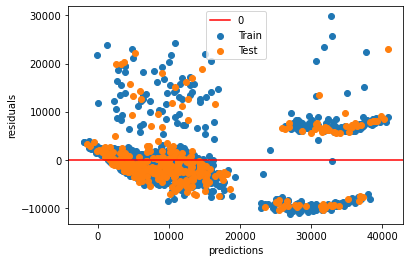

In [38]:
# visualize residuals, for the model that now has cat cols
plt.scatter(train_preds, y_train-train_preds, label='Train')
plt.scatter(test_preds, y_test-test_preds, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

### Evaluate: Thoughts?

- 


#### Some Pros and Cons of OHE:

Pros:

- Simple to understand
- Easy to implement

Cons:

- If the categorical column has many options, or there are a lot of categorical columns, you can add _a lot_ more columns - **curse of dimensionality**
- Resulting columns are very sparse (mostly zeros)
- Resulting columns are directly related (multicollinear)

Also - how do we interpret these coefficients?

In [40]:
# Look at the coefs from our sklearn model
dict(zip(ct.get_feature_names(), lr_ohe.coef_))

{'ohe__x0_male': 45.62242749280853,
 'ohe__x1_yes': 23630.398990299247,
 'ohe__x2_northwest': -355.14862132651433,
 'ohe__x2_southeast': -781.3683889164677,
 'ohe__x2_southwest': -860.2667122325365,
 'age': 11942.687121967849,
 'bmi': 12630.553003885027,
 'children': 2132.5136137240097}

Notice how the model now includes parameters for our dummies! But here's a question: How do we **interpret** them?

In the case of `age`, we have a beta of ~~3643.065~~, and that means that we can expect the insurance charges to grow by ~~3643.065~~ if we increase the person's age by one unit (here, one percent because we min-max scaled our X variables).

But take the beta for `ohe__x1_yes` - where x1 means 'smoker'. The value there is 9546.251. How can we understand this? 

This value encodes the difference we can expect in our target (charges) when we *increase the variable by one unit*. But for this variable, "increasing it by one unit" means going from `ohe__x1_yes=0` to `ohe__x1_yes=1`, and *that* means going from a person who doesn't smoke to one who does! So it's critical always to keep in mind when interpreting the coefficients of categorical variables in a linear regression model that they must be interpreted against a **baseline**, which is where the values of the inputs are 0. Notice that, for the same reason, this also affects the interpretation of the intercept term.

More practice/resources: https://github.com/hoffm386/coefficients-of-dropped-categorical-variables

### Other Encoding Methods?

Certainly there are other ways to turn a categorical column into numeric data that a model can understand.

Some Examples:

- [Label/Ordinal Encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)
- [Frequency Encoding](https://contrib.scikit-learn.org/category_encoders/count.html) (just a count encoder with `normalize=True` to turn into a frequency percentage)
- [Target Encoding](https://contrib.scikit-learn.org/category_encoders/targetencoder.html) (or, relatedly, [Leave-One-Out Encoding](https://contrib.scikit-learn.org/category_encoders/leaveoneout.html) or [Weight of Evidence Encoding](https://contrib.scikit-learn.org/category_encoders/woe.html))

Useful links:

- [Category Encoders](https://contrib.scikit-learn.org/category_encoders/index.html) - library of sklearn-style encoders that implement more encoding methods than those actually packaged in Sklearn
- [Sklearn's Preprocessing Section](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) - user guide section on preprocessing (includes scalers and transformers as well as encoders)

LECTURE ENDED HERE

---------

## Distribution Transformations - AKA Normalizing Variables

### Log Scaling

Linear regression can work better if the predictor and target are normally distributed. 

**Log-scaling** can be a good tool to make *right-skewed* data more normal.

(For *left-skewed* data, which is rarer, we can try transforming our data by raising it to an exponent greater than 1.)

Suppose e.g. a kde plot of my predictor $X$ looks like this:

![original](images/skewplot.png)

In that case, the kde plot of a log-transformed version of $X$ could look like this:

![log](images/logplot.png)

Let's look at our `y` value - how is it distributed?

In [ ]:
y.hist();

That's pretty skewed! Let's see what transforming it would look like.

Log transformation using numpy - [documentation](https://numpy.org/doc/stable/reference/generated/numpy.log.html)

In [ ]:
np.log(y).hist();

Much more normal!

Let's log both our train and test y, then see if our model improves.

In [ ]:
y_train_log = None
y_test_log = None

In [ ]:
# now, let's model!
lr_log = None

# grab predictions for train and test set
train_preds = None
test_preds = None

In [ ]:
# evaluate
print(f"Train R2 Score: {r2_score(y_train_log, train_preds):.3f}")
print(f"Test R2 Score: {r2_score(y_test_log, test_preds):.3f}")

In [ ]:
# visualize residuals, for the model of log-y
plt.scatter(train_preds, y_train_log-train_preds, label='Train')
plt.scatter(test_preds, y_test_log-test_preds, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

### Evaluate - Thoughts?

- 


### Interpreting after Log Transformations

But with this transformed target, how do I now interpret my LR coefficients?


In [ ]:
# Look at coefs for our ohe model
dict(zip(ct.get_feature_names(), lr_ohe.coef_))

In [ ]:
# Now for coefs of our log model
dict(zip(ct.get_feature_names(), lr_log.coef_))

Before the transformation, I would have said that a one-unit increase (and note - units are standard deviations because we scaled our X inputs!) in `age` results on average in a 3643.065 increase in `charges`. 

But what I need to say now is that a one-unit increase in `age` results on average in a 0.486 increase *in the logarithm of price*, i.e. an increase in price by a factor of $e^{0.486}$.

More practically, you can interpret the exponent as a percentage! If you take the exponent of the coefficient minus one, that gives you the percentage increase.

Formula:

$e ^ \text{coef} - 1$

In code:
```
(np.exp(coef) - 1) * 100
```



In [ ]:
# For example:
log_coef_dict = dict(zip(ct.get_feature_names(), lr_log.coef_))

for feature, coef in log_coef_dict.items():
    print(f"A One-Unit Increase in {feature} results on average in a {(np.exp(coef) - 1) * 100}% change in charges")

Note that our binary columns start to get really weird. In practice, before interpreting variables in any practical sense, we'd run one last model without scaling to allow us to better interpret our results - but we'll still likely keep our logged `y` as our target if it improves our model!

Reference:
- https://stats.oarc.ucla.edu/sas/faq/how-can-i-interpret-log-transformed-variables-in-terms-of-percent-change-in-linear-regression/